In [ ]:
!nvidia-smi

Fri Apr 12 06:20:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.4/750.4 kB 9.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

# 1.) Dataset Preparation

The dataset is downloaded (around 0.5GB) and unzipped. The folder is then uploaded to google drive, to be used with google collab for training.

---


# 2.) Understanding YOLO object detector


## 2.1) The YOLO detector

YOLO (You Only Look Once) is a real-time object detection algorithm that handles both object identification and classification in a single pass of the network. It is a single-stage detector, which is different from the R-CNN series taught in class, which are multi-stage detectors, in which , the image is first divided into regions, and then each region is classified as an object or not. This multi-stage detection consisting of proposal of RoIs in the image causes RCNNs to be slow, and not suitable for real time applications. In contrast, YOLO treats the detection task as a single shot regression approach for identifying bounding boxes, making it faster and more suitable for real-time applications. However, the same feature of single-shot detection results in lower accuracy in YOLO models as compared to R-CNN series.

## 2.2) The algorithm

YOLO uses a single CNN to predict both the bounding boxes and class probabilities of objects in an image in a single pass. It works by dividing the input image into a grid of cells. For each cell, it predicts the probability of the presence of an object and the bounding box coordinates of the object, along with the class of the object. The algorithm can be vaguely described as:-

1. The input image is passed through a CNN to extract features from the image.
2. These features are then passed through a series of fully connected layers, which predict class probabilities and bounding box coordinates
3. The image is divided into a grid of cells, and each cell is responsible for predicting a set of bounding boxes and class probabilities.
4. The output of the network is a set of bounding boxes and class probabilities for each cell.
5. The bounding boxes are then filtered using a post-processing algorithm called non-max suppression to remove overlapping boxes and choose the box with the highest probability.
6. The final output is a set of predicted bounding boxes and class labels for each object in the image

## 2.3) Difference between RCNN and YOLO

- YOLO is a single-stage detector, while the R-CNN series is a two-stage detector. In a single-stage detector, object detection and classification are performed simultaneously, while in a two-stage detector, region proposals are generated first, followed by classification.

- Single-stage detectors like YOLO are faster than two-stage detectors like the R-CNN series. However, the R-CNN series tends to be more accurate than single-stage detectors, especially in cases where the objects are small or overlapping

- In the R-CNN series, feature extraction is performed on each region proposal separately, while in YOLO, feature extraction is performed on the entire image. This makes YOLO faster but potentially less accurate in detecting small objects

- YOLO uses anchor boxes to predict bounding boxes, while the R-CNN series uses region proposals. Anchor boxes are predefined bounding boxes with fixed aspect ratios, while region proposals are generated by algorithms such as selective search or edge boxes

- The loss function in YOLO is a combination of classification loss and localization loss, while in the R-CNN series, the loss function is a combination of classification loss, localization loss, and non-maximum suppression (NMS) loss

## 2.4) Different versions of YOLO

* ***YOLOv1:*** (first version) The original YOLO model introduced a novel approach to object detection by dividing the image into a grid and predicting bounding boxes and class probabilities for each grid cell. It was known for its speed, achieving around 155 frames per second (FPS) in its fastest version. However, it struggled with detecting small objects and had lower accuracy compared to later versions 23.

* ***YOLOv3:***(significant increase) This version improved upon the original by using a more complex architecture with 30 convolutional layers, including 19 layers from Darknet-19 and an additional 11 for object detection. It was trained on the COCO dataset and provided more precise detection with good speed. YOLOv3 addressed some of the limitations of YOLOv1, such as its struggle with small objects, and was widely used due to its high precision. It also introduced a more efficient architecture that maintained a good response time with the accuracy offered 3.

* ***YOLOv8:***(used in this question) yolov8 uses a modified version of the CSPDarknet53 architecture as its backbone, which consists of 53 convolutional layers and employs cross-stage partial connections to improve information flow. It also uses a self-attention mechanism in the head of the network, which allows the model to focus on different parts of the image and adjust the importance of different features. Additionally, YOLOv8 can perform multi-scaled object detection using a feature pyramid network, which detects objects of different sizes and scales within an image.

---

In [ ]:
import ultralytics
ultralytics.checks()
from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random
import shutil
import cv2
# Mount Google Drive
from google.colab import drive


Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/107.7 GB disk)


# 3.) Hands on with ultralytics

In [ ]:
# initializing yolov8n and yolov8m model
yolo_n = YOLO('yolov8n.yaml')
yolo_m = YOLO('yolov8m.yaml')


In [ ]:

# finding out the number of training parameters and number of convolutional layers
num_params_yolo_n = sum(p.numel() for p in yolo_n.parameters())
print("Parameters in YOLOv8n :", num_params_yolo_n)
conv_layers_yolo_n = sum(1 for m in yolo_n.modules() if isinstance(m, torch.nn.Conv2d))
print("Convolutional layers in YOLOv8n :", conv_layers_yolo_n)

num_params_yolo_m = sum(p.numel() for p in yolo_m.parameters())
print("Parameters in YOLOv8m :", num_params_yolo_m)
conv_layers_yolo_m = sum(1 for m in yolo_m.modules() if isinstance(m, torch.nn.Conv2d))
print("Convolutional layers in YOLOv8m :", conv_layers_yolo_m)



Parameters in YOLOv8n : 3157200
Convolutional layers in YOLOv8n : 64
Parameters in YOLOv8m : 25902640
Convolutional layers in YOLOv8m : 84


The number of parameters and number of convolutional layers in the `yolov8n` and `yolov8m` model clearly implies that `yolov8m` is a fairly more complex model than `yolov8n`, having more layers and more trainable parameters.

In [ ]:
  # mounting google drive
from google.colab import drive
drive.mount('/content/drive')

# Define root directory
root_dir = '/content/drive/My Drive/Colab Notebooks'

Mounted at /content/drive


# 4.1) Creating `train1` and `train2` datasets containing 100 and 400 images

In [ ]:
# Define directories for train1 images and labels
train1_images_dir = os.path.join(root_dir, 'images', 'train1')
train1_labels_dir = os.path.join(root_dir, 'labels', 'train1')

# Create train1 directories if they don't exist
os.makedirs(train1_images_dir, exist_ok=True)
os.makedirs(train1_labels_dir, exist_ok=True)

num_images = 100
selected_images = random.sample(os.listdir(os.path.join(root_dir, 'images', 'train')), num_images)
for image in selected_images:
    shutil.copy(os.path.join(root_dir, 'images', 'train', image), os.path.join(train1_images_dir, image))
    shutil.copy(os.path.join(root_dir, 'labels', 'train', image.replace('.png', '.txt')), os.path.join(train1_labels_dir, image.replace('.png', '.txt')))

print(num_images," images copied to train1!")

100  images copied to train1!


# 4.2) Training YOLO variants
## **Variant 1 :** `yolov8-n` initialized from scratch on `train1` (100 images)

In [ ]:
yolov8n = YOLO('yolov8n.yaml')
results= yolov8n.train(data='/content/drive/MyDrive/Colab Notebooks/config1.yaml', epochs=20)
metrics = yolov8n.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab Notebooks/config1.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

100%|██████████| 755k/755k [00:00<00:00, 21.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 127MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train1... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:01<00:00, 77.36it/s]


train: New cache created: /content/drive/My Drive/Colab Notebooks/labels/train1.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:38<00:00,  1.31it/s]

val: New cache created: /content/drive/My Drive/Colab Notebooks/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.42G      3.357      4.378      4.346          8        640: 100%|██████████| 7/7 [00:07<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.23s/it]

                   all         50         52    0.00217      0.615    0.00451    0.00151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.31G       3.56      4.296      4.265         12        640: 100%|██████████| 7/7 [00:01<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         50         52    0.00218      0.615    0.00796    0.00253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.32G      3.505      4.242      4.219          6        640: 100%|██████████| 7/7 [00:01<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50         52     0.0023      0.615    0.00578    0.00209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.31G      3.264      4.062      4.205         11        640: 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         50         52    0.00233      0.654    0.00584    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.32G      3.279      4.015      4.161          6        640: 100%|██████████| 7/7 [00:01<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         50         52    0.00231      0.654    0.00485    0.00152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.31G      3.265      3.946      4.134         11        640: 100%|██████████| 7/7 [00:01<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         52    0.00234      0.654    0.00532    0.00159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.32G      3.303      4.263      4.066          7        640: 100%|██████████| 7/7 [00:01<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         50         52    0.00226      0.635    0.00511    0.00157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.32G      3.162      3.944      3.991          7        640: 100%|██████████| 7/7 [00:02<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         50         52    0.00228      0.635    0.00564    0.00161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.32G      3.186      3.867      3.992          9        640: 100%|██████████| 7/7 [00:01<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         50         52    0.00235      0.654    0.00571    0.00183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.31G      2.891      3.949      3.934          7        640: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]


                   all         50         52    0.00228      0.635     0.0052     0.0017
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.32G      2.907      4.404      3.851          4        640: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         50         52    0.00224      0.615    0.00628     0.0019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.32G      2.837      4.552      3.802          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         50         52    0.00225      0.596     0.0105    0.00291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      2.986       4.36      3.743          5        640: 100%|██████████| 7/7 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         50         52    0.00232      0.615     0.0124    0.00395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.29G      2.735      4.198       3.76          4        640: 100%|██████████| 7/7 [00:02<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         50         52    0.00222      0.596     0.0132     0.0064



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.28G      2.853      4.438      3.652          4        640: 100%|██████████| 7/7 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         52    0.00222      0.596    0.00754    0.00231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.29G      2.759      4.181      3.645          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.75it/s]

                   all         50         52     0.0023      0.615    0.00755    0.00228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.29G      2.803       4.17      3.597          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         50         52    0.00231      0.615     0.0081    0.00245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.29G      2.781      4.109        3.6          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         50         52    0.00239      0.635     0.0077    0.00242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.28G      2.734      4.225      3.565          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         50         52     0.0024      0.635    0.00952    0.00299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.29G       2.69      4.142       3.52          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         50         52    0.00249      0.615     0.0237    0.00825



20 epochs completed in 0.025 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


                   all         50         52    0.00248      0.615     0.0241    0.00837
Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]


                   all         50         52     0.0026      0.635     0.0252    0.00876
Speed: 1.8ms preprocess, 31.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)


AP50 result on train and validation sets
AP50 on train :  0.024061335856025812
AP50 on val   :  0.025222441059013955


---
## **Variant 2 :** pre-trained `yolov8-n` on `train1` (100 images)

In [ ]:
yolov8n_pt = YOLO('yolov8n.pt')
results= yolov8n_pt.train(data='/content/drive/MyDrive/Colab Notebooks/config1.yaml', epochs=20)
metrics = yolov8n_pt.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/config1.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train1.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.37G      1.035       3.09       1.25          8        640: 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         50         52     0.0034      0.981      0.627       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.38G      1.064      2.527      1.186         12        640: 100%|██████████| 7/7 [00:03<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         50         52      0.748      0.172      0.475       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.38G      1.008      2.328      1.161          6        640: 100%|██████████| 7/7 [00:02<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         52     0.0034      0.981      0.602      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.38G     0.9568      2.108      1.125         11        640: 100%|██████████| 7/7 [00:02<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         50         52     0.0034      0.981       0.51       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.38G      1.002      2.146       1.22          6        640: 100%|██████████| 7/7 [00:02<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all         50         52      0.231      0.808      0.525      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.38G     0.9588      1.921      1.216         11        640: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         50         52          1     0.0566      0.499      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.36G      1.006      2.229      1.138          7        640: 100%|██████████| 7/7 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         50         52      0.898      0.169      0.558      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.35G     0.9574      1.915      1.154          7        640: 100%|██████████| 7/7 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         50         52      0.736      0.519      0.573      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.36G      1.089      1.937      1.269          9        640: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         52      0.539      0.308      0.409      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.34G      1.039      1.985      1.196          7        640: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         50         52      0.423      0.442      0.347      0.204


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.35G      1.003       2.65      1.287          4        640: 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         50         52      0.366      0.478      0.333      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.35G      1.046       2.69      1.232          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         50         52      0.629      0.519      0.514      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.35G      1.053       2.59      1.239          5        640: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         50         52      0.644      0.481      0.543      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.35G     0.9031      2.317      1.245          4        640: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         50         52      0.595      0.615      0.577      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.34G     0.9494      2.368      1.157          4        640: 100%|██████████| 7/7 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         50         52      0.759      0.546      0.582      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.35G     0.9314      2.199      1.185          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]

                   all         50         52      0.769      0.558      0.631      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.35G     0.8391      2.046      1.134          4        640: 100%|██████████| 7/7 [00:01<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         50         52      0.704      0.615      0.641      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.35G     0.8346      1.988      1.152          4        640: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         50         52      0.722      0.551      0.651      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.34G     0.7995      2.013       1.05          4        640: 100%|██████████| 7/7 [00:01<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         50         52      0.799      0.577      0.684      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.35G     0.8306      1.917       1.06          4        640: 100%|██████████| 7/7 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         50         52      0.857      0.576      0.707      0.517



20 epochs completed in 0.027 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]


                   all         50         52      0.857      0.577      0.707      0.517
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train3
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]


                   all         50         52      0.827      0.577      0.709       0.52
Speed: 1.2ms preprocess, 9.9ms inference, 0.0ms loss, 13.0ms postprocess per image
Results saved to runs/detect/train32


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)

AP50 result on train and validation sets
AP50 on train :  0.7067290154727596
AP50 on val   :  0.7087043004608329


---
## **Variant 3 :** pre-trained `yolov8-m` on `train1` (100 images)

In [ ]:
yolov8m_pt = YOLO('yolov8m.pt')
results= yolov8m_pt.train(data='/content/drive/MyDrive/Colab Notebooks/config1.yaml', epochs=20)
metrics = yolov8m_pt.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/Colab Notebooks/config1.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=T

train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train1.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.37G      1.006      3.021      1.293          8        640: 100%|██████████| 7/7 [00:06<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all         50         52      0.748      0.808      0.689      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       7.6G     0.9553      2.429      1.227         12        640: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         52       0.45       0.75      0.509      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       7.6G      1.007      1.941       1.26          6        640: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         50         52        0.5      0.423      0.424      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       7.6G     0.9703      1.928      1.218         11        640: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         50         52      0.433        0.5      0.335      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.62G      1.098      1.802       1.32          6        640: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         50         52     0.0618      0.327     0.0461      0.014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       7.6G       1.07      1.769      1.336         11        640: 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]

                   all         50         52     0.0351      0.423     0.0269     0.0123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      7.64G      1.255      2.338      1.391          7        640: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         50         52    0.00708      0.519     0.0049    0.00123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      7.26G      1.222       1.82      1.412          7        640: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         50         52     0.0157      0.462     0.0289    0.00845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       7.3G      1.215      1.796      1.414          9        640: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         50         52    0.00478      0.462    0.00354    0.00238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      7.25G       1.32      1.881       1.56          7        640: 100%|██████████| 7/7 [00:03<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         50         52    0.00263      0.327    0.00176   0.000445


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      7.29G      1.323      2.002      1.627          4        640: 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         50         52     0.0287      0.327     0.0161    0.00424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       7.3G      1.356      1.947      1.609          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         50         52     0.0324      0.288     0.0149    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.26G      1.276      1.919        1.5          5        640: 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         52     0.0415      0.192     0.0238    0.00992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      7.29G      1.358      1.935      1.662          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         50         52      0.127      0.481     0.0873     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      7.28G      1.243      1.923      1.376          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         50         52      0.137      0.538      0.108      0.043



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      7.28G       1.29        1.9       1.53          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         50         52      0.253      0.654      0.329      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.26G      1.062      1.564       1.32          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         50         52      0.229      0.525      0.276      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.28G       1.01      1.491      1.326          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         50         52      0.339      0.538      0.401      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      7.29G     0.9922      1.378      1.248          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         50         52      0.577      0.558      0.515      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      7.29G      1.011      1.328      1.296          4        640: 100%|██████████| 7/7 [00:03<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         50         52      0.523      0.558      0.555       0.35



20 epochs completed in 0.036 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 52.0MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


                   all         50         52      0.748      0.808      0.689      0.535
Speed: 0.2ms preprocess, 9.6ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train5
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


                   all         50         52      0.749      0.808       0.69      0.535
Speed: 0.8ms preprocess, 50.9ms inference, 0.0ms loss, 5.1ms postprocess per image
Results saved to runs/detect/train52


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)

AP50 result on train and validation sets
AP50 on train :  0.6891645052410481
AP50 on val   :  0.6902814950602802


---
## **Variant 4 :** `yolov8-n` initialized from scratch on `train` (400 images)

In [ ]:
yolov8n_400 = YOLO('yolov8n.yaml')
results= yolov8n_400.train(data='/content/drive/MyDrive/Colab Notebooks/config.yaml', epochs=20)
metrics = yolov8n_400.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab Notebooks/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:49<00:00,  6.43it/s]


train: New cache created: /content/drive/My Drive/Colab Notebooks/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.81G      3.402      4.329      4.272         31        640: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all         50         52    0.00227      0.635      0.012    0.00612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.84G       3.31      4.088      4.151         25        640: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         50         52    0.00228      0.635    0.00543    0.00179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.84G      3.193       3.97      3.969         23        640: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         50         52    0.00213      0.615    0.00365    0.00096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.84G      3.203      3.879      3.793         23        640: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         50         52    0.00344      0.558    0.00472    0.00143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.84G      3.015      3.762      3.579         29        640: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         50         52    0.00714      0.462     0.0165    0.00464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.84G      2.998      3.698      3.421         28        640: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         50         52    0.00932      0.385     0.0247    0.00652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.84G      2.861      3.561      3.276         24        640: 100%|██████████| 20/20 [00:09<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         50         52    0.00554     0.0769    0.00444    0.00167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.84G      2.817      3.462      3.227         28        640: 100%|██████████| 20/20 [00:09<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         50         52     0.0387     0.0385    0.00776    0.00265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.84G      2.772      3.366      3.143         33        640: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         50         52      0.119     0.0962     0.0857     0.0244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.84G      2.724       3.34       3.13         24        640: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         50         52      0.144     0.0385     0.0383     0.0101


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.84G       2.63      3.673      3.052         13        640: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         50         52     0.0625      0.519     0.0944     0.0205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.84G      2.583      3.551      3.061         13        640: 100%|██████████| 20/20 [00:09<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         50         52      0.155     0.0385      0.078     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.84G      2.525      3.378      2.997         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         52     0.0544      0.327     0.0609      0.019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.84G      2.506      3.305      2.992         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         50         52      0.271      0.423        0.2     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.84G      2.442      3.255      2.966         12        640: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         50         52      0.209      0.212      0.153     0.0365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.84G      2.428      3.192      3.024         13        640: 100%|██████████| 20/20 [00:09<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         50         52      0.329      0.154      0.122     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20       2.8G      2.374      3.132      2.942         13        640: 100%|██████████| 20/20 [00:08<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         50         52      0.301      0.231      0.173     0.0612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       2.8G      2.378      3.105      2.867         12        640: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         50         52      0.382       0.25      0.252     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       2.8G      2.372      3.074       2.85         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         52      0.384      0.365      0.284     0.0875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.79G       2.32      2.989      2.869         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         50         52      0.319       0.36      0.213     0.0701



20 epochs completed in 0.073 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]


                   all         50         52      0.389      0.365      0.284     0.0878
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train6
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


                   all         50         52      0.362      0.346      0.278     0.0863
Speed: 1.1ms preprocess, 33.1ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/train62


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)

AP50 result on train and validation sets
AP50 on train :  0.28427206198585964
AP50 on val   :  0.2776743734943221


---
## **Variant 5 :** pre-trained `yolov8-n` on `train` (400 images)

In [ ]:
yolov8n_pt_400 = YOLO('yolov8n.pt')
results= yolov8n_pt_400.train(data='/content/drive/MyDrive/Colab Notebooks/config.yaml', epochs=20)
metrics = yolov8n_pt_400.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train.cache... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.41G       1.05       2.78      1.215         31        640: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         50         52     0.0034      0.981      0.511      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       2.3G      1.052      2.211      1.213         25        640: 100%|██████████| 20/20 [00:10<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         50         52      0.627      0.365      0.444      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       2.3G      1.123      2.158      1.221         23        640: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         50         52      0.493      0.423      0.391      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.29G      1.149      2.111      1.262         23        640: 100%|██████████| 20/20 [00:11<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         50         52      0.341      0.462      0.348      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.29G      1.194      2.054      1.292         29        640: 100%|██████████| 20/20 [00:10<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         50         52      0.559      0.341      0.346      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.29G      1.206      2.079      1.311         28        640: 100%|██████████| 20/20 [00:09<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         50         52      0.486      0.404      0.374      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.29G      1.221      2.008      1.301         24        640: 100%|██████████| 20/20 [00:09<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         52      0.464      0.385      0.304      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.29G      1.162      1.818      1.259         28        640: 100%|██████████| 20/20 [00:10<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         50         52       0.53      0.538       0.56      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.29G      1.092      1.722      1.212         33        640: 100%|██████████| 20/20 [00:11<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         50         52       0.72      0.594      0.652       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.29G      1.108      1.743      1.233         24        640: 100%|██████████| 20/20 [00:10<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         50         52      0.484      0.654      0.522      0.311


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.29G      1.115      2.035      1.331         13        640: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         50         52      0.428      0.481      0.426      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.29G      1.074      1.887      1.287         13        640: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         50         52      0.614      0.538      0.594      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.29G      1.022       1.75      1.236         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         50         52       0.76      0.608      0.664      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.24G      0.993      1.699      1.243         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         50         52      0.713      0.712      0.744      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.24G     0.9616       1.63      1.181         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         50         52      0.811      0.615      0.723      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.24G     0.8951      1.529      1.151         13        640: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         50         52       0.77      0.673      0.791      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.24G     0.8751      1.468      1.129         13        640: 100%|██████████| 20/20 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         50         52      0.795      0.654       0.77      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.24G     0.8218      1.414      1.093         12        640: 100%|██████████| 20/20 [00:09<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         52       0.74      0.673      0.755      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.24G     0.7976      1.347      1.088         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         50         52      0.808      0.654      0.772      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.24G     0.7439      1.275      1.048         12        640: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         50         52      0.763      0.731        0.8      0.622



20 epochs completed in 0.073 hours.
Optimizer stripped from runs/detect/train8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train8/weights/best.pt, 6.2MB

Validating runs/detect/train8/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]


                   all         50         52      0.763      0.731        0.8      0.627
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train8
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


                   all         50         52      0.761      0.731      0.793       0.62
Speed: 0.2ms preprocess, 30.7ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train82


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)

AP50 result on train and validation sets
AP50 on train :  0.8002303073826752
AP50 on val   :  0.7928676784782512


---
## **Variant 6 :** pre-trained `yolov8-m` on `train` (400 images)

In [ ]:
yolov8m_pt_400 = YOLO('yolov8m.yaml')
results= yolov8m_pt_400.train(data='/content/drive/MyDrive/Colab Notebooks/config.yaml', epochs=20)
metrics = yolov8m_pt_400.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/drive/MyDrive/Colab Notebooks/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train.cache... 316 images, 0 backgrounds, 0 corrupt: 100%|██████████| 316/316 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.42G      3.407      4.261       4.22         31        640: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all         50         52    0.00224      0.635    0.00577    0.00162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      7.64G      3.343       3.94      4.073         25        640: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         50         52    0.00227      0.654     0.0197    0.00455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      7.65G      3.166      3.788      3.842         23        640: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         50         52    0.00481      0.481    0.00525    0.00181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       7.3G      3.075      3.672      3.677         23        640: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         50         52     0.0222      0.346     0.0235    0.00642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      7.33G      2.895       3.68      3.557         29        640: 100%|██████████| 20/20 [00:12<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         50         52     0.0191     0.0385    0.00386   0.000868



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       7.3G      2.959      3.675      3.498         28        640: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         50         52     0.0478      0.135     0.0246    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       7.3G      2.868      3.555      3.292         24        640: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         50         52     0.0628      0.135      0.034    0.00757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       7.3G      2.799      3.512      3.213         28        640: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         50         52     0.0209      0.115     0.0284    0.00581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       7.3G      2.758      3.437      3.188         33        640: 100%|██████████| 20/20 [00:12<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all         50         52    0.00542      0.808     0.0665     0.0179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       7.3G      2.655       3.38       3.13         24        640: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         50         52    0.00733      0.462     0.0109    0.00267


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       7.3G      2.631      3.565      3.097         13        640: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         50         52    0.00411      0.462     0.0114    0.00296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20       7.3G      2.548      3.457      3.034         13        640: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         50         52    0.00188     0.0962    0.00265   0.000739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      7.29G      2.539      3.436      3.051         12        640: 100%|██████████| 20/20 [00:12<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         50         52     0.0154     0.0769     0.0226    0.00701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20       7.3G      2.505      3.334      3.057         12        640: 100%|██████████| 20/20 [00:12<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         52       0.12      0.481      0.134      0.041



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       7.3G      2.538      3.264      3.074         12        640: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         50         52      0.162      0.288      0.161     0.0517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20       7.3G       2.48      3.169      3.013         13        640: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         50         52       0.14      0.135     0.0943     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      7.29G      2.437      3.093      3.015         13        640: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         50         52      0.225       0.25      0.121     0.0334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      7.29G      2.432      3.073      2.919         12        640: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         50         52      0.218      0.288      0.177     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       7.3G      2.373      3.045      2.887         12        640: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         50         52      0.199      0.235      0.133      0.045



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20       7.3G      2.412      2.963       2.91         12        640: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         50         52      0.203       0.25      0.127     0.0465



20 epochs completed in 0.094 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 52.0MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]


                   all         50         52      0.218      0.288      0.177     0.0568
Speed: 0.2ms preprocess, 10.3ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train9
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8m summary (fused): 218 layers, 25840339 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


                   all         50         52      0.207      0.269      0.171     0.0569
Speed: 0.3ms preprocess, 44.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/detect/train92


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)

AP50 result on train and validation sets
AP50 on train :  0.1770563266623892
AP50 on val   :  0.17092687417406835


---

# 4.3) Comparing performance of the 6 variations

**AP50 score for trainset**

|            | yolov8n (scratch)    | yolov8n (pre-trained) | yolov8m (pre-trained) |   |   |   |   |   |   |
|------------|----------------------|-----------------------|-----------------------|---|---|---|---|---|---|
| 100 images | 0.024061335856025812 | 0.7067290154727596    | 0.6891645052410481    |   |   |   |   |   |   |
| 400 images | 0.28427206198585964  |  0.8002303073826752   | 0.1770563266623892    |   |   |   |   |   |   |


**AP50 score for valset**

|            | yolov8n (scratch)    | yolov8n (pre-trained) | yolov8m (pre-trained) |   |   |   |   |   |   |
|------------|----------------------|-----------------------|-----------------------|---|---|---|---|---|---|
| 100 images | 0.025222441059013955 | 0.7087043004608329    | 0.6902814950602802    |   |   |   |   |   |   |
| 400 images | 0.2776743734943221   | 0.7928676784782512    | 0.17092687417406835   |   |   |   |   |   |   |


## Observations and Analysis [answers to (a) and (b)]

- `yolov8n` performs worst when trained from scratch, but performs the best when using the pre-trained model file.
- `yolov8m` performs moderately well (maybe since it is pre-trained, again).
- A drastic increase in performance is seen for `yolov8n` (scratch) when the training samples are increased from 100 to 400 (around 10x). Whereas in `yolov8n` (pre-trained), (where the AP50 scores were already very high for 100 samples), the AP50 scores increase, but not as much as compared to `yolov8n` (scratch).
- However, for `yolov8m` model, the AP50 score decreases when the number of train samples are increased from 100 to 400.
- This disparity in AP50 scores can be a result of the complexity of the `yolov8n` and `yolov8m` models themselves. `yolov8m` model while being fairly comples itself, performs good on 100 samples, whereas tends to overfit and poor generalization of data for larger samples, thus resulting in a lower AP50. `yolov8n`, being a relatively simpler model, tends to require more data to perform better, thus resulting in a larger AP50 for more train data.


---

# 4.4) Visualizing results for 4 images in `val` set

- `327236c0ef04c7f0.png` : multiple ducks, occulusion by grass, several other objects, different orientations, low resolution
- `310275a7da893e8c.png` : multiple ducks, different poses (flying), motion blur
- `1c3a9c074c042ba6.png` : incomplete picture of the duck. doesnt look like duck
- `11ef736947e18c52.png` : occuluded by sticks, difficult to segment

The 4 images capture a diverse variations of the trainset and can help us analyze when does the model fail to perform and why.

### Analysis

- **For Image 1** : We can see that the ducks in the image are present in a small area only, thereby reducing the resolution of the objects to be identified. Also, they are partially occuluded by grass. Moreover, the different poses of the ducks make it difficult for the model to detect and segment them. The model therefore is unable to detect ducks in this image.

- *For Image 2* : This image has ducks clearly visible, but in rather uncommon poses as compared to other images in the trainset. We see flying ducks in the image. However, the model is able to detect 1 out of 3 ducks in this image. Not optimal performance, but not total failure either.

- *For Image 3* : This image contains a close-up image of a single duck taken from the front. The image makes it difficult for even some humans to identify the duck, but after careful observation, similar images were found in the trainset, which made model learn to detect duck in this position.

- *For Image 4* : The duck is very well occuluded by the nest/sticks around it. It appears in a very small region of the image and the matching color of the occulusion with the duck makes it even difficult for the model to identify. The model fails for this sample.


In [ ]:
val_images_dir = os.path.join(root_dir, 'images', 'val')
selected_image_files = ['327236c0ef04c7f0.png', '310275a7da893e8c.png', '1c3a9c074c042ba6.png', '11ef736947e18c52.png']

model = yolov8n_pt_400
results = model([os.path.join(val_images_dir, image) for image in selected_image_files])

for i, result in enumerate(results):
    result.show()
    result.save(filename=f'result{i}.jpg')
    print(result.boxes.xyxy)



0: 640x640 (no detections), 7.1ms
1: 640x640 1 duck, 7.1ms
2: 640x640 1 duck, 7.1ms
3: 640x640 (no detections), 7.1ms
Speed: 3.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
tensor([], device='cuda:0', size=(0, 4))
tensor([[ 91.9747, 266.3989, 385.1992, 498.6798]], device='cuda:0')
tensor([[ 370.5791,  142.9365, 1024.0000,  768.0000]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 4))


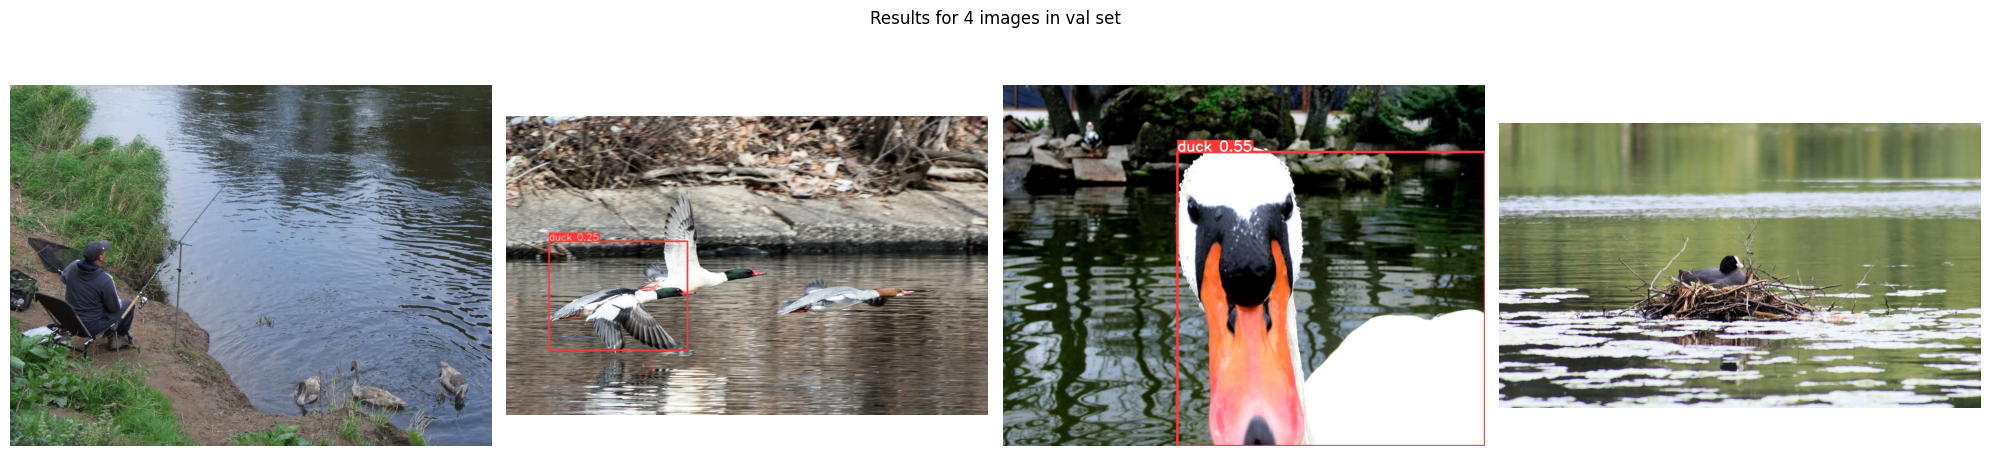

In [ ]:
image_files = ['result0.jpg', 'result1.jpg', 'result2.jpg', 'result3.jpg']
fig, axes = plt.subplots(1, len(image_files), figsize=(20, 5))

for ax, image_file in zip(axes, image_files):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax.imshow(image)
    ax.axis('off')

fig.suptitle("Results for 4 images in val set")
plt.tight_layout()
plt.show()



# 5.) Agumentations in training the models

## 5.1) Default Agumentations in YOLOv8n

The default run on which all the above models are trained use **Agumentations**. On observing the output logs, the following agumentations are found :-

- *Blur Agumentation :* Applies a blur effect on the image. It can possibly stimulate real-world scenarios where images may appear blurry due to factors such as motion blur, out-of-focus camera settings, or poor image quality.

- *Median Blur :* Applies a median filtering to the image. Similar to Blur, it also smooths out the image.

- *ToGray :* Converts the input image to a grayscale. Helps the model perform better in color variations and variations in illuminations by removing color information.

- *CLAHE :* Contrast Limited Adaptive Histogram Equalization (CLAHE) enhances the contrast of an image while limiting the amplification of noise in regions with low contrast. This also provides lighting variations to the image, helping the model learn better.

## Removing agumentations on pre-trained `yolov8-n` model.

In [ ]:
# command to remove albumentations
!pip3 uninstall -y albumentations

Found existing installation: albumentations 1.3.1
Uninstalling albumentations-1.3.1:
  Successfully uninstalled albumentations-1.3.1


In [ ]:
model = YOLO('yolov8n.pt')
results= model.train(data='/content/drive/MyDrive/Colab Notebooks/config1.yaml', epochs=20)
metrics = model.val()

Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Colab Notebooks/config1.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /content/drive/My Drive/Colab Notebooks/labels/train1.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      1.186      3.014      1.325         11        640: 100%|██████████| 7/7 [01:29<00:00, 12.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.47s/it]

                   all         50         52     0.0034      0.981       0.64      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      1.073      2.445      1.176         14        640: 100%|██████████| 7/7 [01:26<00:00, 12.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.79s/it]

                   all         50         52      0.384      0.788      0.598      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      1.009      2.176      1.174         10        640: 100%|██████████| 7/7 [01:28<00:00, 12.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.58s/it]

                   all         50         52     0.0034      0.981      0.664      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G     0.9332      2.091      1.168          8        640: 100%|██████████| 7/7 [01:26<00:00, 12.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.63s/it]

                   all         50         52     0.0034      0.981      0.586      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G      1.007      2.084      1.136          7        640: 100%|██████████| 7/7 [01:31<00:00, 13.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.10s/it]

                   all         50         52      0.665      0.346      0.542      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G       1.02      2.061      1.202          5        640: 100%|██████████| 7/7 [01:24<00:00, 12.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.63s/it]

                   all         50         52       0.95      0.368      0.646       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G     0.9905      1.853      1.163          8        640: 100%|██████████| 7/7 [01:23<00:00, 12.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:14<00:00,  7.03s/it]

                   all         50         52      0.829      0.279      0.477      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      0.993      1.798      1.139         10        640: 100%|██████████| 7/7 [01:30<00:00, 12.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.50s/it]

                   all         50         52      0.706      0.404      0.509      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G     0.9504       1.84      1.152          9        640: 100%|██████████| 7/7 [01:27<00:00, 12.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.79s/it]

                   all         50         52      0.631      0.442      0.576      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G     0.8814      1.623      1.094         13        640: 100%|██████████| 7/7 [01:24<00:00, 12.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.16s/it]

                   all         50         52      0.534      0.481      0.543      0.347


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      0.909      2.454      1.156          4        640: 100%|██████████| 7/7 [01:38<00:00, 14.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.75s/it]

                   all         50         52      0.538      0.327      0.346      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.018      2.586       1.22          4        640: 100%|██████████| 7/7 [01:36<00:00, 13.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:17<00:00,  8.84s/it]

                   all         50         52      0.623      0.327      0.411      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G     0.9743      2.403      1.193          4        640: 100%|██████████| 7/7 [01:36<00:00, 13.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:18<00:00,  9.20s/it]

                   all         50         52      0.657      0.423      0.508      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G     0.8889      2.205      1.168          4        640: 100%|██████████| 7/7 [01:35<00:00, 13.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:16<00:00,  8.35s/it]

                   all         50         52      0.586      0.423      0.434      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G     0.9156      2.195      1.189          5        640: 100%|██████████| 7/7 [01:26<00:00, 12.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.80s/it]

                   all         50         52      0.496        0.5      0.495      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G     0.8478      2.039      1.087          4        640: 100%|██████████| 7/7 [01:16<00:00, 10.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.79s/it]

                   all         50         52      0.524        0.5      0.474      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G     0.8596      2.001      1.111          4        640: 100%|██████████| 7/7 [01:19<00:00, 11.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.76s/it]

                   all         50         52      0.479      0.481      0.451      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G     0.8346      2.072      1.111          4        640: 100%|██████████| 7/7 [01:27<00:00, 12.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.81s/it]

                   all         50         52      0.447      0.596      0.503      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G     0.8452      1.999      1.155          4        640: 100%|██████████| 7/7 [01:18<00:00, 11.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.72s/it]

                   all         50         52       0.53      0.558      0.547      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      0.772      1.985       1.09          4        640: 100%|██████████| 7/7 [01:16<00:00, 10.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:13<00:00,  6.71s/it]

                   all         50         52       0.57      0.662      0.614       0.45



20 epochs completed in 0.576 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.09s/it]


                   all         50         52     0.0034      0.981      0.664      0.484
Speed: 2.1ms preprocess, 190.3ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/train3
Ultralytics YOLOv8.1.47 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/drive/My Drive/Colab Notebooks/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:13<00:00,  3.46s/it]


                   all         50         52     0.0034      0.981      0.665       0.49
Speed: 2.2ms preprocess, 198.1ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train32


In [ ]:
print("AP50 result on train and validation sets")
print("AP50 on train : ", results.results_dict['metrics/mAP50(B)'])
print("AP50 on val   : ", metrics.box.map50)

AP50 result on train and validation sets
AP50 on train :  0.6643490720140717
AP50 on val   :  0.665239685076882


---

## 5.2) Impact of Agumentations on AP50 score

The AP50 score for `yolov8n.pt` model for 100 images using agumentations was `0.7067290154727596`, where as the score drops to ` 0.6643490720140717` when training without any agumentations. The change in AP50 score is not that significant, but definitly not negligible. Such a increase in Average Precision if critical in some usecases where we might call it significant increase. The increase in AP50 score generally should be significant. The low increase observed in our case is majorly due to dataset. In our ducks dataset, maybe agumentations dont really provide much variation to the model since the object to be detected (ducks) is mostly alike and visually similar in most aspects. Moreover, the agumentations the model runs on by default might already be present in the dataset to some extent, resulting in a small (~6%) increase in agumented training as compared to non-agumented.

However, the increase in AP50 score can be explained on the basis of the role of agumentations in increasing the diversity of the training data by generating new samples with variations in appearance and content. This expanded dataset helps the model learn more representative features and improves its ability to detect objects in a wider range of conditions.

---

## 5.3) Which augmentation is the most important?

- Random Rotation : Since most of the images of ducks are taken with the camera aligned horizonatlly with the ground, the dataset, in some extent, fails to capture images from different perspectives. Thus, an agumentation that randomly rotates some of the train images might provide useful diversity to the model and help it perform better.

- Random resize and crop : Almost all of the images in the trainset have negligible occlusion of the ducks. The shape of ducks are fully visible and pretty similar. A variation in partially occuluded or cropped images using agumentations might be helpful to the model.


***How did you determine this?***

The impact of various agumentations can be determined by manually observing the effect of each type of agumentation on the AP50 score. This will give empirically true results and is the best method. However, owing to the training and evaluation time of the models plus the number of agumentations to be tried, it is a reasonable good approach to decide the best agumentation just by **observing the dataset**. On observing the dataset on which the model is being trained, we can infer which type of variations one might observe in the real world, which are not present in the dataset. How the images in the trainset are similar in some aspects and those agumentations in those aspects might provide most variability to the model and improve its performance more.

---